This problem aims at helpig a security camera identify and distinguish images that are vehicles and non-vehicls.

Steps in Creating a Vehicle Recognition Model

*   Import libraries
*   Connect Google Colab to Kaggle and Download dataset
*   Load the images into training and validation set
*   Inspect the shape
*   Build the model: by rescaling, using conv2d layer, max2d pooling, flatten and the output dense layer.
*   Using 'relu' as the activation function for each layer, 'SparseCategoricalEntropy' as loss function and 'sigmoid' as activation for output layer.
*   

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [2]:
 #from google.colab import files
 #files.upload()

In [3]:
# Create a kaggle folder
# ! mkdir ~/.kaggle

In [4]:
# Copy the kaggle.json file into the /.kaggle folder
#! cp kaggle.json ~/.kaggle/

In [5]:
# Permission for the json to be executed.

#!chmod 600 ~/.kaggle/kaggle.json

In [6]:
#! kaggle datasets download -d brsdincer/vehicle-detection-image-set -p Dataset

In [7]:
#!unzip Dataset/vehicle-detection-image-set.zip

In [8]:
# Select the directory
vehiclesdir_ = Path('/content/data/')

# Create the filepath using the directory
filepaths = list(vehiclesdir_.glob(r'**/*.png'))

# Select the labels
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Paths and Labels
filepaths = pd.Series(filepaths, name='File').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenating both the paths and labels
df = pd.concat([filepaths, labels], axis=1)

df = df.sample(frac=1, random_state = 42).reset_index(drop= True)

Text(0.5, 1.0, 'Number of images in the Training Set')

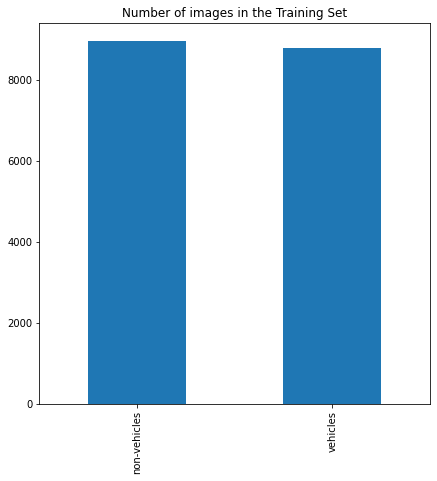

In [9]:
plt.figure(figsize=(7, 7))
labels.value_counts().plot(kind='bar')
plt.title('Number of images in the Training Set')

In [10]:
import random
test_size = 0.2

random_images = np.random.randint(0, (1 - test_size) * len(labels))

In [11]:
plt.style.use('dark_background')

Text(0.5, 1.0, 'non-vehicles')

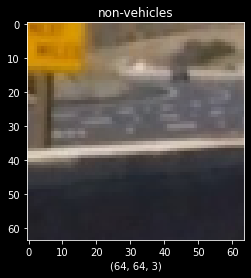

In [12]:
figure = plt.figure(figsize= (4, 4))
x = plt.imread(df["File"][20])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df['Label'][20])

In [13]:
df.head(3)

,File,Label
0,/content/data/vehicles/1524.png,vehicles
1,/content/data/vehicles/5945.png,vehicles
2,/content/data/vehicles/3812.png,vehicles


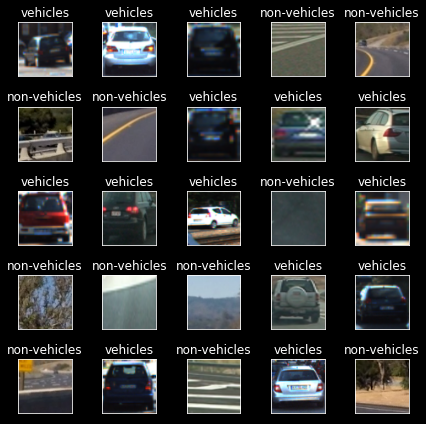

In [14]:
fig, axes = plt.subplots(5, 5, figsize=(6, 6), 
                         subplot_kw= {"xticks": [], "yticks": []})

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df['File'][i]))
  ax.set_title(df['Label'][i])
plt.tight_layout()
plt.show()

In [15]:
batch_size = 32
img_height = 32
img_width = 32

In [16]:
train_df = tf.keras.preprocessing.image_dataset_from_directory(vehiclesdir_, validation_split= 0.2, subset= 'training',
                                                               seed= 42, image_size= (img_height, img_width), batch_size = batch_size)

val_df = tf.keras.preprocessing.image_dataset_from_directory(vehiclesdir_, validation_split=0.2, subset= 'validation',
                                                             seed= 42, image_size = (img_height, img_width), batch_size = batch_size)

Found 17760 files belonging to 2 classes.
Using 14208 files for training.
Found 17760 files belonging to 2 classes.
Using 3552 files for validation.


In [17]:
train_df.class_names

['non-vehicles', 'vehicles']

In [18]:
for image_batch, labels_batch in train_df:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 32, 32, 3)
(32,)


In [19]:
num_classes = len(train_df.class_names)

model = tf.keras.Sequential([
                             tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
                             tf.keras.layers.Conv2D(32, 3, activation='relu'),
                             tf.keras.layers.MaxPool2D(),
                             tf.keras.layers.Conv2D(32, 3, activation= 'relu'),
                             tf.keras.layers.MaxPool2D(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(2, activation='sigmoid')
])

model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer= tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

history = model.fit(train_df, validation_data= val_df, epochs= 10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


444/444 [==============================] - 26s 56ms/step - loss: 0.1934 - accuracy: 0.9261 - val_loss: 0.1116 - val_accuracy: 0.9609
Epoch 2/10
444/444 [==============================] - 24s 53ms/step - loss: 0.0840 - accuracy: 0.9711 - val_loss: 0.0675 - val_accuracy: 0.9778
Epoch 3/10
444/444 [==============================] - 24s 54ms/step - loss: 0.0556 - accuracy: 0.9812 - val_loss: 0.0621 - val_accuracy: 0.9786
Epoch 4/10
444/444 [==============================] - 24s 54ms/step - loss: 0.0408 - accuracy: 0.9859 - val_loss: 0.0344 - val_accuracy: 0.9885
Epoch 5/10
444/444 [==============================] - 24s 54ms/step - loss: 0.0334 - accuracy: 0.9888 - val_loss: 0.0368 - val_accuracy: 0.9876
Epoch 6/10
444/444 [==============================] - 23s 53ms/step - loss: 0.0261 - accuracy: 0.9912 - val_loss: 0.0262 - val_accuracy: 0.9899
Epoch 7/10
444/444 [==============================] - 25s 57ms/step - loss: 0.0191 - accuracy: 0.9928 - val_loss: 0.0544 - val_accuracy: 0.9837
Epo

There seems to be an increase in validation loss and a decrease in validation accuracy after the 5th epoch but the validation loss soon decreased while the accuracy also increased.

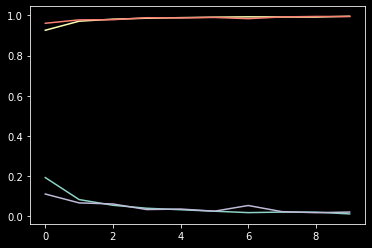

In [20]:
plt.plot(pd.DataFrame(history.history))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

The model had a 99% accuracy... That's an accuracy good enough to recognize vehicles in a security camera or sensor designed to automatically permit an access control to permit the passage of an incoming vehicle.

SAVE THE MODEL

In [22]:
model.save('Vehicle_Recognition_Model_a')

INFO:tensorflow:Assets written to: Vehicle_Recognition_Model_a/assets


In [23]:
model.save('Vehicle_Recognition_Model_b.h5')